In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/google-fpt-telecom-reviews-data','/kaggle/input/vietnamese-stopwords/stopwords.txt','/kaggle/input/train-classificate-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv


## Cài đặt các thư viện

In [3]:
!pip install -q py_vncorenlp stop_words underthesea

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
stop_words_vi = get_stop_words('vi')
import py_vncorenlp
from tqdm import tqdm
import networkx as nx
from collections import Counter

import pandas as pd
from nltk import ngrams
from gensim.models import Word2Vec
from wordcloud import WordCloud

import sys
import importlib
import collections
import itertools
import matplotlib.pyplot as plt
import logging

## Khởi tạo môi trường cho VnCoreNLP

In [5]:
# Cài đặt Java
!apt-get install openjdk-11-jdk -y

# Thiết lập JAVA_HOME
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libice-dev libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmcp-dev libxt-dev openjdk-11-jdk-headless x11proto-dev
  xorg-sgml-doctools xtrans-dev
Suggested packages:
  libice-doc libsm-doc libx11-doc libxcb-doc libxt-doc openjdk-11-demo
  openjdk-11-source visualvm
The following NEW packages will be installed:
  libice-dev libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmcp-dev libxt-dev openjdk-11-jdk openjdk-11-jdk-headless x11proto-dev
  xorg-sgml-doctools xtrans-dev
0 upgraded, 13 newly installed, 0 to remove and 67 not upgraded.
Need to get 76.9 MB of archives.
After this operation, 90.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 xorg-sgml-doctools all 1:1.11-1.1 [10.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 

In [7]:
import py_vncorenlp
from tqdm import tqdm

save_dir = '/kaggle/working/vncorenlp'
# Kiểm tra và tạo thư mục lưu trữ nếu chưa tồn tại
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Tự động tải các thành phần của VnCoreNLP vào thư mục save_dir
py_vncorenlp.download_model(save_dir=save_dir)

--2024-10-02 10:05:54--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: 'VnCoreNLP-1.2.jar'

     0K .......... .......... .......... .......... ..........  0% 2.30M 11s
    50K .......... .......... .......... .......... ..........  0% 13.1M 7s
   100K .......... .......... .......... .......... ..........  0% 6.66M 6s
   150K .......... .......... .......... .......... ..........  0% 17.3M 5s
   200K .......... .......... .......... .......... ..........  0% 25.9M 4s
   250K .......... .......... .......... .......... ..........  1% 8.53M 4s
   300K .......... .......... .......... .......... ..........  1% 71.3M 3s
   350K .

## Tiền xử lý dữ liệu

In [8]:
data = pd.read_csv('/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv')
if 'Review Text' in data.columns:
    # Thay thế các giá trị NaN trong cột 'Review Text' bằng chuỗi rỗng
    data['Review Text'] = data['Review Text'].fillna("")


In [9]:
import re
import string
from underthesea import word_tokenize  
import pandas as pd

vietnamese_stopwords_file = '/kaggle/input/vietnamese-stopwords/stopwords.txt' 

# Đọc các từ dừng tiếng Việt từ file
with open(vietnamese_stopwords_file, 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

def preprocess_text(text):

    # Chuyển văn bản thành chữ thường
    text = text.lower()

    # Loại bỏ URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r" ", text)

    # Loại bỏ thẻ HTML
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # Loại bỏ dấu câu và số
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    text = " ".join(text.split())

    # Loại bỏ emoji
    emoji_pattern = re.compile("[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    # Tokenize text sử dụng underthesea
    tokens = word_tokenize(text)

    # Loại bỏ các từ dừng tiếng Việt
    filtered_tokens = [word for word in tokens if word.lower() not in vietnamese_stopwords]

    return " ".join(filtered_tokens)


In [10]:
# Tách cột Review Text
data['Review Text'] = data['Review Text'].apply(preprocess_text)
review_text = data['Review Text']

# Định nghĩa đường dẫn file đầu ra
output_file_path = '/kaggle/working/review_text.txt'

# Lưu cột Review Text vào file .txt
with open(output_file_path, 'w', encoding='utf-8') as file:
    for review in review_text:
        file.write(review + '\n')

## Sử dụng VnCoreNLP để tiền xử lý và tách ra các chủ thể trong review

In [13]:
input_file = "/kaggle/working/review_text.txt"
output_file = "/kaggle/working/output_segmented.txt"

# Gọi phương thức annotate_file để xử lý tệp đầu vào và lưu kết quả vào tệp đầu ra
rdrsegmenter.annotate_file(input_file=input_file, output_file=output_file)
with open(output_file, 'r', encoding='utf-8') as f:
    output_content = f.read()

# Tách nội dung thành từng câu bằng dấu xuống dòng
sentences = output_content.split('\n')

# Kiểm tra kết quả
for sentence in sentences:
    print(sentence)

2024-10-02 10:07:14 INFO  Annotation:100 - Start processing /kaggle/working/review_text.txt
2024-10-02 10:07:14 INFO  Annotation:113 - Wrote output to /kaggle/working/output_segmented.txt
1	internet	N	O	_		_
2	chập_chờn	V	O	_		_
3	chụp	V	O	_		_
4	ảnh	N	O	_		_
5	báo	V	O	_		_
6	nhân_viên	N	O	_		_
7	kỹ_thuật	N	O	_		_
8	nguyễn_minh	V	O	_		_
9	quang	N	O	_		_
10	ta	P	O	_		_
11	bảo	V	O	_		_
12	kiểm_tra	V	O	_		_
13	báo	N	O	_		_
14	báo	N	O	_		_
15	gọi	V	O	_		_
16	điện_thoại	N	O	_		_
17	gọi	V	O	_		_
18	dt	A	O	_		_
19	zalo	N	O	_		_
20	đề_nghị	V	O	_		_
21	khắc_phục	V	O	_		_
22	đồng_tình	V	O	_		_
23	ý_kiến	N	O	_		_

1	phản_ánh	V	O	_		_
2	dịch_vụ	N	O	_		_
3	bảo_hành	V	O	_		_
4	camera	Nb	O	_		_
5	tư_vấn	V	O	_		_
6	hướng	N	O	_		_
7	giải_quyết	V	O	_		_
8	báo	N	O	_		_
9	khách	N	O	_		_
10	hành	V	O	_		_
11	chờ	V	O	_		_
12	phản_hồi	V	O	_		_
13	chờ	V	O	_		_
14	phản_hồi	V	O	_		_
15	gọi	V	O	_		_
16	khách_hàng	N	O	_		_
17	thông_báo	V	O	_		_
18	làm_việc	V	O	_		_
19	tắc_trách	V	O	_		_
20	camera	Nb	O	_		_
21	fpt	

In [32]:
# Chuyển đổi nội dung đầu ra thành một danh sách các dòng
lines = output_content.strip().split('\n')

# Khởi tạo danh sách để lưu trữ dữ liệu
data = []
current_sentence = []
entities = set()  # Sử dụng set để đảm bảo các thực thể không bị lặp

# Duyệt qua từng dòng để xác định câu và các thực thể
for line in lines:
    if not line.strip():  # Bỏ qua dòng trống (đánh dấu câu kết thúc)
        if current_sentence:  # Nếu có câu đang xây dựng thì lưu lại
            data.append({
                'Segmented Sentence': ' '.join(current_sentence),
                'Entities': ', '.join(entities)
            })
            current_sentence = []
            entities = set()  # Reset lại set thực thể cho câu tiếp theo
        continue  # Tiếp tục với dòng tiếp theo
    
    parts = line.split('\t')
    
    # Lấy từ và nhãn thực thể
    if len(parts) < 5:  # Kiểm tra xem dòng có đủ phần không
        continue

    word = parts[1]  # Từ
    ner_tag = parts[2]  # Nhãn thực thể
    
    # Thêm từ vào câu
    current_sentence.append(word)
    
    # Kiểm tra nếu nhãn thực thể không phải là 'O' và có '_' trong từ hoặc là từ riêng
    if ner_tag == 'N' or ner_tag == 'Nb':
        if '_' in word or word in ['internet', 'camera']:
            entities.add(word)  # Thêm từ vào set

# Xử lý trường hợp câu cuối cùng không kết thúc bằng dòng trống
if current_sentence:
    data.append({
        'Segmented Sentence': ' '.join(current_sentence),
        'Entities': ', '.join(entities)
    })

# Chuyển đổi dữ liệu thành DataFrame
df_final = pd.DataFrame(data)

# Tách các thực thể thành các cột riêng biệt
entity_columns = df_final['Entities'].str.split(', ', expand=True)
entity_columns.columns = [f'Entity {i + 1}' for i in range(entity_columns.shape[1])]

# Kết hợp với DataFrame chính
df_final = pd.concat([df_final[['Segmented Sentence']], entity_columns], axis=1)

# Hiển thị DataFrame cuối cùng
df_final

,Segmented Sentence,Entity 1,Entity 2,Entity 3,Entity 4,Entity 5,Entity 6
0,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,nhân_viên,ý_kiến,điện_thoại,kỹ_thuật,internet,None
1,phản_ánh dịch_vụ bảo_hành camera tư_vấn hướng ...,camera,chất_lượng,fpt,dịch_vụ,sản_phẩm,khách_hàng
2,đăng_ký dịch_vụ tuyệt_vời huỷ hết_sức điều_tra...,ngôi_sao,dịch_vụ,None,None,None,None
3,dịch_vụ lừa_đảo tư_vấn tư_vấn dv quyền_lợi lật...,khách_hàng,dịch_vụ,quyền_lợi,None,None,None
4,dịch_vụ nhân_viên phục_vụ nhanh_chóng,nhân_viên,dịch_vụ,None,None,None,None
...,...,...,...,...,...,...,...
66,nhà_cung_cấp dịch_vụ internet,internet,nhà_cung_cấp,dịch_vụ,None,None,None
67,dịch_vụ khách_hàng kém,khách_hàng,dịch_vụ,None,None,None,None
68,đẹp,,None,None,None,None,None
69,xinbchao,,None,None,None,None,None


## Ngrams 

In [33]:
import pandas as pd
from nltk import ngrams

# Định nghĩa hàm ngram
def ngram(string, n=1):
    # Bỏ dấu phẩy và tách thành từ
    words = string.replace(',', '').split()
    if len(words) < n:  # Kiểm tra nếu số từ ít hơn n
        return []  # Trả về danh sách rỗng
    gram_str = list(ngrams(words, n))
    return [" ".join(gram).lower() for gram in gram_str] 

df_final["Segmented Sentence"] = df_final["Segmented Sentence"].str.replace(',', '', regex=False)

# Áp dụng n-gram cho cột 'Segmented Sentence'
df_final["unigram"] = df_final["Segmented Sentence"].apply(lambda t: ngram(t, 1))
df_final["bigram"] = df_final["Segmented Sentence"].apply(lambda t: ngram(t, 2))

df_final

,Segmented Sentence,Entity 1,Entity 2,Entity 3,Entity 4,Entity 5,Entity 6,unigram,bigram
0,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,nhân_viên,ý_kiến,điện_thoại,kỹ_thuật,internet,None,"[internet, chập_chờn, chụp, ảnh, báo, nhân_viê...","[internet chập_chờn, chập_chờn chụp, chụp ảnh,..."
1,phản_ánh dịch_vụ bảo_hành camera tư_vấn hướng ...,camera,chất_lượng,fpt,dịch_vụ,sản_phẩm,khách_hàng,"[phản_ánh, dịch_vụ, bảo_hành, camera, tư_vấn, ...","[phản_ánh dịch_vụ, dịch_vụ bảo_hành, bảo_hành ..."
2,đăng_ký dịch_vụ tuyệt_vời huỷ hết_sức điều_tra...,ngôi_sao,dịch_vụ,None,None,None,None,"[đăng_ký, dịch_vụ, tuyệt_vời, huỷ, hết_sức, đi...","[đăng_ký dịch_vụ, dịch_vụ tuyệt_vời, tuyệt_vời..."
3,dịch_vụ lừa_đảo tư_vấn tư_vấn dv quyền_lợi lật...,khách_hàng,dịch_vụ,quyền_lợi,None,None,None,"[dịch_vụ, lừa_đảo, tư_vấn, tư_vấn, dv, quyền_l...","[dịch_vụ lừa_đảo, lừa_đảo tư_vấn, tư_vấn tư_vấ..."
4,dịch_vụ nhân_viên phục_vụ nhanh_chóng,nhân_viên,dịch_vụ,None,None,None,None,"[dịch_vụ, nhân_viên, phục_vụ, nhanh_chóng]","[dịch_vụ nhân_viên, nhân_viên phục_vụ, phục_vụ..."
...,...,...,...,...,...,...,...,...,...
66,nhà_cung_cấp dịch_vụ internet,internet,nhà_cung_cấp,dịch_vụ,None,None,None,"[nhà_cung_cấp, dịch_vụ, internet]","[nhà_cung_cấp dịch_vụ, dịch_vụ internet]"
67,dịch_vụ khách_hàng kém,khách_hàng,dịch_vụ,None,None,None,None,"[dịch_vụ, khách_hàng, kém]","[dịch_vụ khách_hàng, khách_hàng kém]"
68,đẹp,,None,None,None,None,None,[đẹp],[]
69,xinbchao,,None,None,None,None,None,[xinbchao],[]


In [34]:
import pandas as pd
from nltk import bigrams

# Giả sử bạn đã có DataFrame df với cột 'unigram'
# df = pd.DataFrame({"unigram": [["example", "text"], ["another", "example"]]})

# Tạo bigram từ các unigram
terms_bigram = [list(bigrams(tweet)) for tweet in df_final["unigram"] if len(tweet) > 1]  # Chỉ lấy những tweet có nhiều hơn 1 từ

# Kiểm tra kết quả của bigram đầu tiên
if terms_bigram:
    print(terms_bigram[0])  # In bigram đầu tiên nếu có
else:
    print("Không có bigram nào được tạo.")

[('internet', 'chập_chờn'), ('chập_chờn', 'chụp'), ('chụp', 'ảnh'), ('ảnh', 'báo'), ('báo', 'nhân_viên'), ('nhân_viên', 'kỹ_thuật'), ('kỹ_thuật', 'nguyễn_minh'), ('nguyễn_minh', 'quang'), ('quang', 'ta'), ('ta', 'bảo'), ('bảo', 'kiểm_tra'), ('kiểm_tra', 'báo'), ('báo', 'báo'), ('báo', 'gọi'), ('gọi', 'điện_thoại'), ('điện_thoại', 'gọi'), ('gọi', 'dt'), ('dt', 'zalo'), ('zalo', 'đề_nghị'), ('đề_nghị', 'khắc_phục'), ('khắc_phục', 'đồng_tình'), ('đồng_tình', 'ý_kiến')]


In [35]:
bigrams = list(itertools.chain(*terms_bigram))
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_counts.most_common(25)

[(('fpt', 'telecom'), 4),
 (('nhân_viên', 'nhiệt_tình'), 3),
 (('chờ', 'phản_hồi'), 2),
 (('nhân_viên', 'vui_vẻ'), 2),
 (('phòng', 'giao_dịch'), 2),
 (('internet', 'truyền_hình'), 2),
 (('chất_lượng', 'dịch_vụ'), 2),
 (('truyền_hình', 'fpt'), 2),
 (('nhân_viên', 'thân_thiện'), 2),
 (('dịch_vụ', 'fpt'), 2),
 (('dịch_vụ', 'internet'), 2),
 (('internet', 'chập_chờn'), 1),
 (('chập_chờn', 'chụp'), 1),
 (('chụp', 'ảnh'), 1),
 (('ảnh', 'báo'), 1),
 (('báo', 'nhân_viên'), 1),
 (('nhân_viên', 'kỹ_thuật'), 1),
 (('kỹ_thuật', 'nguyễn_minh'), 1),
 (('nguyễn_minh', 'quang'), 1),
 (('quang', 'ta'), 1),
 (('ta', 'bảo'), 1),
 (('bảo', 'kiểm_tra'), 1),
 (('kiểm_tra', 'báo'), 1),
 (('báo', 'báo'), 1),
 (('báo', 'gọi'), 1)]

## Visualize

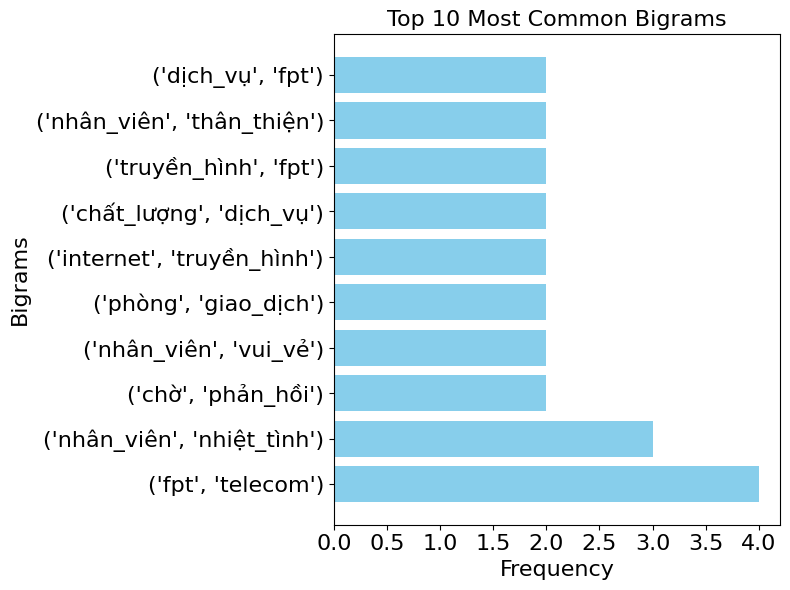

In [36]:
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)
top_25_bigrams = bigram_counts.most_common(25)
bigram_labels, counts = zip(*top_25_bigrams[:10])

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(range(len(bigram_labels)), counts, color='skyblue')
plt.yticks(range(len(bigram_labels)), bigram_labels,fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Bigrams',fontsize=16)
plt.title('Top 10 Most Common Bigrams',fontsize=16)
plt.tight_layout()
plt.savefig('bigram_hist.pdf')
plt.show()

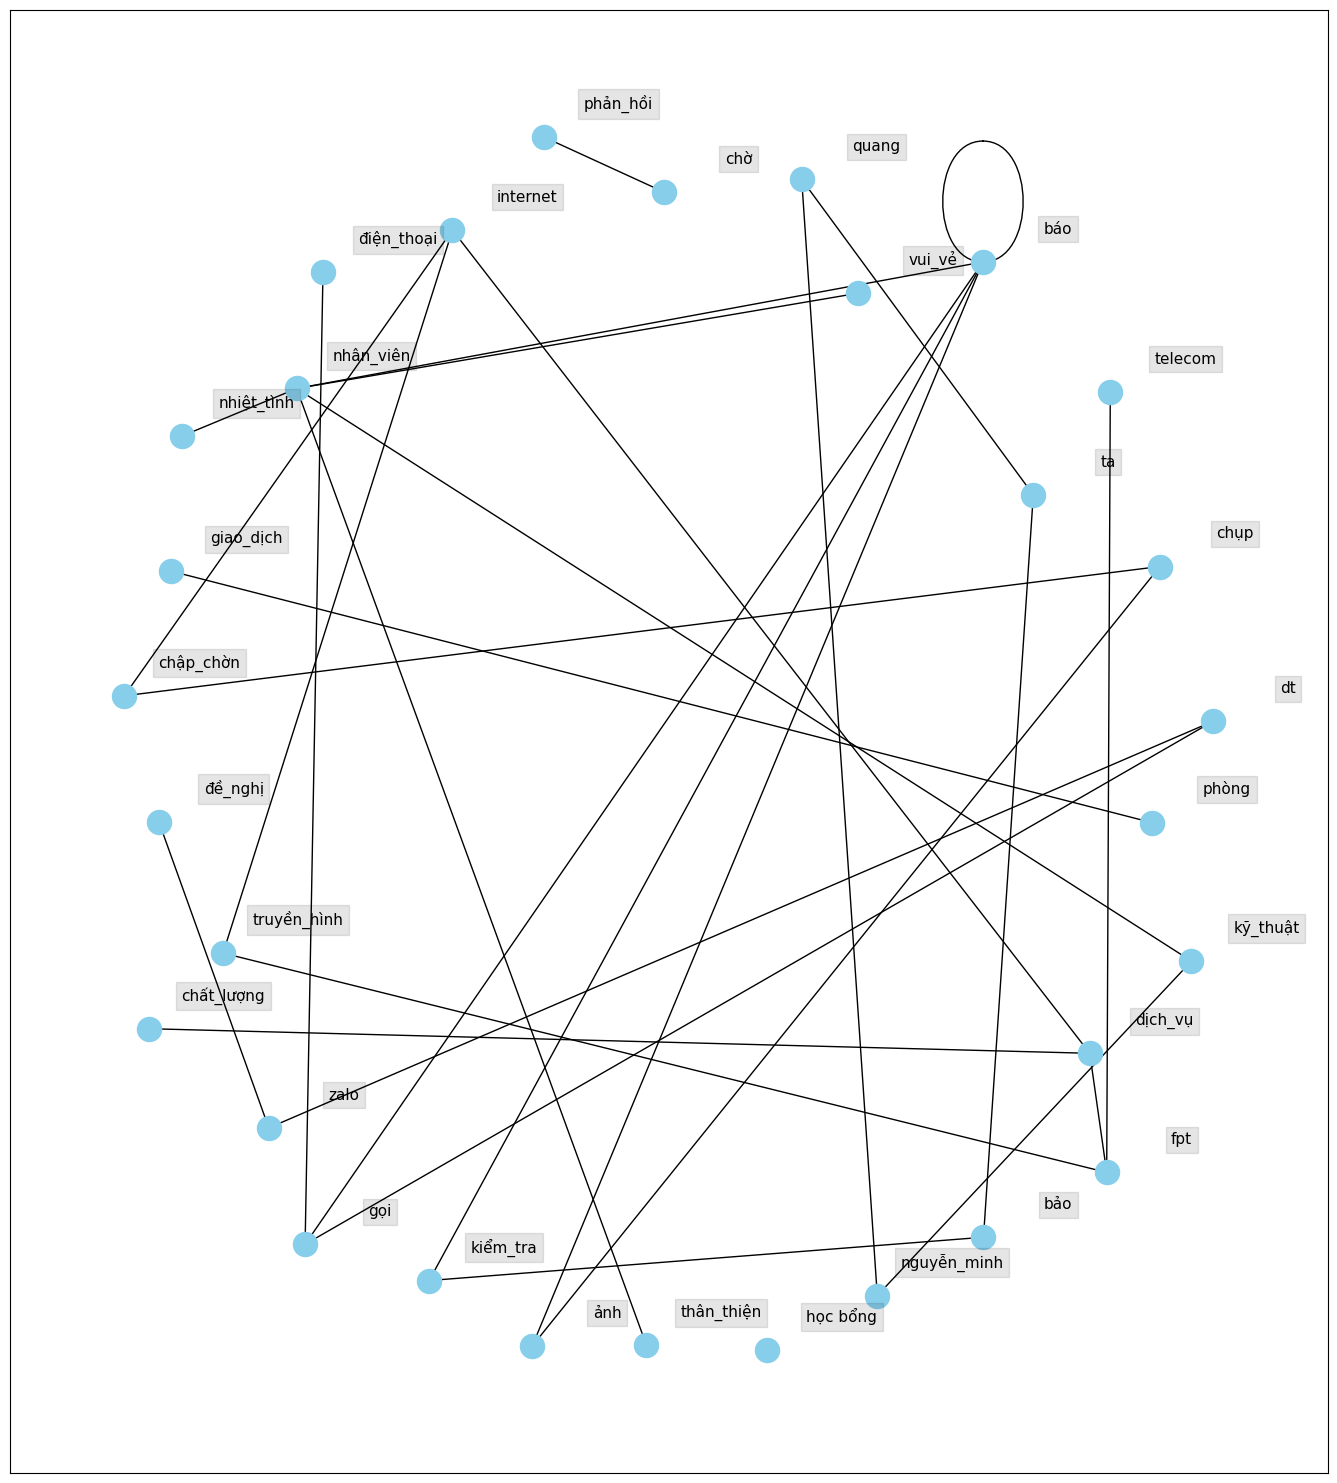

In [37]:

bigram_df = pd.DataFrame(bigram_counts.most_common(30),columns=['unigram', 'count'])

d = bigram_df.set_index('unigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("học bổng", weight=100) # Thêm node sad tỏng G

fig, ax = plt.subplots(figsize=(17, 19))
pos = nx.spring_layout(G, k=10)

nx.draw_networkx(G, pos,
                 edge_color='black',
                 node_color='skyblue',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='black', alpha=0.10),
            horizontalalignment='center', fontsize=11)
plt.savefig('wordnet.pdf')
plt.show()

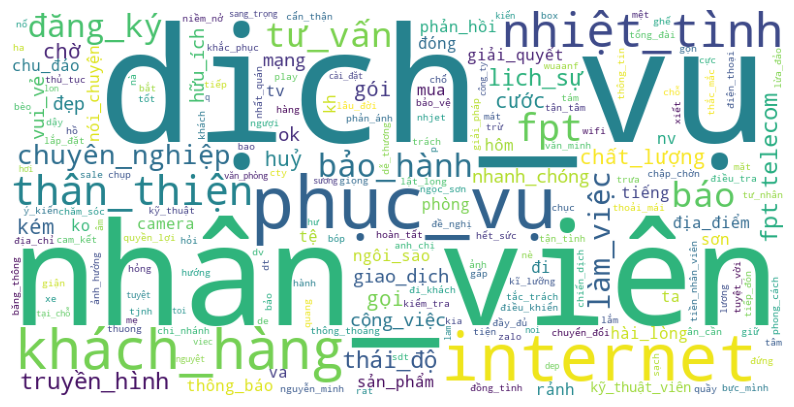

In [38]:
text = " ".join(df_final['Segmented Sentence'])
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='viridis',
                      stopwords=None).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud.pdf')
plt.show()

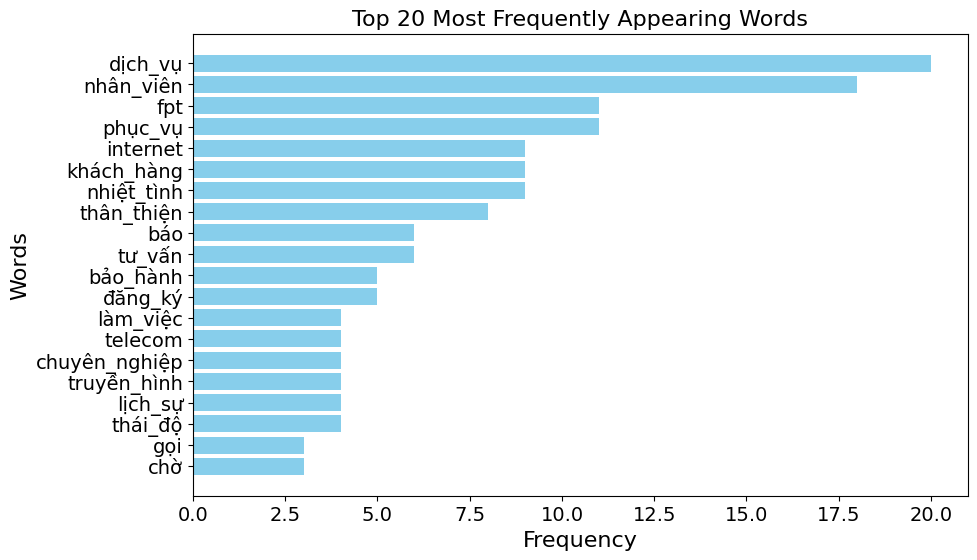

In [39]:
text = " ".join(df_final['Segmented Sentence'])
words = text.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(20)
top_words, word_freqs = zip(*top_20_words)

# Plot the top 20 words
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_freqs, color='skyblue')
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Words',fontsize=16)
plt.title('Top 20 Most Frequently Appearing Words',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.savefig('word-freq.pdf')
plt.show()

In [24]:
data = pd.read_csv('/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv')
data['Review Time'].value_counts()

Review Time
5 năm trước        46
4 năm trước        34
3 năm trước        22
6 năm trước        18
2 năm trước        15
7 năm trước        14
8 năm trước         7
một năm trước       5
9 năm trước         2
một tuần trước      1
6 tháng trước       1
8 tháng trước       1
một tháng trước     1
2 tháng trước       1
3 tháng trước       1
11 tháng trước      1
11 năm trước        1
Name: count, dtype: int64

In [25]:
import pandas as pd
from datetime import datetime, timedelta

# Giả sử df đã được tạo và có cột 'Review Time'
# df = pd.DataFrame({"Review Time": ["5 năm trước", "4 năm trước", "một năm trước", "một tuần trước", ...]})

# Lấy ngày hiện tại
nowdate = datetime.now()

# Từ điển ánh xạ số từ chữ sang số nguyên
number_map = {
    'một': 1,
    'hai': 2,
    'ba': 3,
    'bốn': 4,
    'năm': 5,
    'sáu': 6,
    'bảy': 7,
    'tám': 8,
    'chín': 9,
    'mười': 10
}

# Hàm chuyển đổi 'Review Time' thành ngày
def convert_to_date(review_time):
    parts = review_time.split()
    
    if len(parts) == 3:  # Xử lý trường hợp như 'một tuần trước'
        num_str = parts[0]
        unit = parts[1]
        
        # Xử lý trường hợp số chữ
        if num_str in number_map:
            number = number_map[num_str]
        else:
            try:
                number = int(num_str)  # Chuyển đổi số nguyên nếu có thể
            except ValueError:
                return pd.NaT  # Trả về NaT nếu không thể chuyển đổi
        
        if 'năm' in unit:
            return nowdate - timedelta(days=number * 365)  # Cứ 1 năm = 365 ngày
        elif 'tháng' in unit:
            return nowdate - timedelta(days=number * 30)  # Cứ 1 tháng = 30 ngày
        elif 'tuần' in unit:
            return nowdate - timedelta(weeks=number)  # Cứ 1 tuần = 7 ngày
    return pd.NaT  # Nếu không phải định dạng hợp lệ

# Áp dụng hàm chuyển đổi cho cột 'Review Time'
data['Review Date'] = data['Review Time'].apply(convert_to_date)

# Kiểm tra kết quả
data[['Review Time', 'Review Date']]

,Review Time,Review Date
0,một tuần trước,2024-09-25 10:09:03.532790
1,một tháng trước,2024-09-02 10:09:03.532790
2,6 tháng trước,2024-04-05 10:09:03.532790
3,8 tháng trước,2024-02-05 10:09:03.532790
4,2 năm trước,2022-10-03 10:09:03.532790
...,...,...
166,7 năm trước,2017-10-04 10:09:03.532790
167,7 năm trước,2017-10-04 10:09:03.532790
168,8 năm trước,2016-10-04 10:09:03.532790
169,8 năm trước,2016-10-04 10:09:03.532790


In [26]:
data['Rating'] = data['Rating'].apply(lambda x: int(x.replace(' sao', '')))

In [27]:
import pandas as pd
import plotly.express as px

data['Review Date'] = pd.to_datetime(data['Review Date'])

data['Year'] = data['Review Date'].dt.year

avg_rating_per_year = data.groupby('Year')['Rating'].mean().reset_index()

fig = px.line(avg_rating_per_year, x='Year', y='Rating', 
              title='Trung bình Rating theo năm', 
              labels={'Rating': 'Trung bình Rating', 'Year': 'Năm'},
              markers=True)  

fig.show()

In [ ]:
# from transformers import MarianMTModel, MarianTokenizer

# # Đặt mô hình và tokenizer cho dịch sang tiếng Anh
# model_name_en = "Helsinki-NLP/opus-mt-vi-en"
# tokenizer_en = MarianTokenizer.from_pretrained(model_name_en)
# model_en = MarianMTModel.from_pretrained(model_name_en)

# # Đặt mô hình và tokenizer cho dịch ngược lại sang tiếng Việt
# model_name_vi = "Helsinki-NLP/opus-mt-en-vi"
# tokenizer_vi = MarianTokenizer.from_pretrained(model_name_vi)
# model_vi = MarianMTModel.from_pretrained(model_name_vi)

# def back_translate(text):
#     # Dịch sang tiếng Anh
#     translated_en = model_en.generate(**tokenizer_en.prepare_seq2seq_batch(text, return_tensors="pt"))
#     translated_text_en = tokenizer_en.decode(translated_en[0], skip_special_tokens=True)

#     # Dịch ngược lại sang tiếng Việt
#     translated_vi = model_vi.generate(**tokenizer_vi.prepare_seq2seq_batch(translated_text_en, return_tensors="pt"))
#     translated_text_vi = tokenizer_vi.decode(translated_vi[0], skip_special_tokens=True)

#     return translated_text_vi

# # Ví dụ sử dụng
# original_text = "Chào bạn, hôm nay thời tiết thật đẹp!"
# back_translated_text = back_translate(original_text)
# print(back_translated_text)


In [28]:
!pip install transformers

In [48]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

# Load the ABSA model and tokenizer
model_name = "UchihaMadara/ABSA-MaskedLM-Vietnamese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Giả sử df_final là DataFrame đã có cột 'Segmented Sentence' và các cột Entity
results = []  # Danh sách để lưu kết quả

for index, row in df_final.iterrows():
    segmented_sentence = row['Segmented Sentence']
    
    # Lấy danh sách các entity không phải None
    entities = [value for value in row[1:] if value is not None]
    
    # Phân tích cảm xúc cho từng entity
    for entity in entities:
        # Kiểm tra xem entity có phải là danh sách hay không
        if isinstance(entity, list):
            continue  # Bỏ qua các entity là danh sách

        text_to_classify = f"{segmented_sentence} {entity}"
        sentiment = classifier(text_to_classify)
        
        # Lấy label và score, làm tròn score đến 2 số thập phân
        label = sentiment[0]['label']
        score = round(sentiment[0]['score'], 2)
        
        # Lưu kết quả vào danh sách với thông tin về câu
        results.append({'Segmented Sentence': segmented_sentence, 'Entity': entity, 'Sentiment': {'label': label, 'score': score}})

# Chuyển danh sách kết quả thành DataFrame
results_df = pd.DataFrame(results)

# Chuyển đổi LABEL_1 thành 'tiêu cực' và LABEL_0 thành 'tích cực'
results_df['Sentiment'] = results_df['Sentiment'].apply(lambda x: {
    'label': 'tiêu cực' if x['label'] == 'LABEL_1' else 'tích cực',
    'score': x['score']
})

# Hiển thị DataFrame kết quả
results_df


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at UchihaMadara/ABSA-MaskedLM-Vietnamese and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


,Segmented Sentence,Entity,Sentiment
0,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,nhân_viên,"{'label': 'LABEL_1', 'score': 0.52}"
1,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,ý_kiến,"{'label': 'LABEL_1', 'score': 0.52}"
2,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,điện_thoại,"{'label': 'LABEL_1', 'score': 0.51}"
3,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,kỹ_thuật,"{'label': 'LABEL_1', 'score': 0.52}"
4,internet chập_chờn chụp ảnh báo nhân_viên kỹ_t...,internet,"{'label': 'LABEL_1', 'score': 0.54}"
...,...,...,...
116,dịch_vụ khách_hàng kém,khách_hàng,"{'label': 'LABEL_1', 'score': 0.55}"
117,dịch_vụ khách_hàng kém,dịch_vụ,"{'label': 'LABEL_1', 'score': 0.53}"
118,đẹp,,"{'label': 'LABEL_0', 'score': 0.5}"
119,xinbchao,,"{'label': 'LABEL_1', 'score': 0.52}"


In [43]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Tải mô hình sentiment tổng cho câu
model_name = "mr4/phobert-base-vi-sentiment-analysis"  # Sử dụng mô hình phù hợp
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Giả sử results_df là DataFrame đầu vào của bạn đã chứa cột Sentiment
# Tách label và score từ cột Sentiment
results_df['Sentiment Label'] = results_df['Sentiment'].apply(lambda x: x['label'])
results_df['Sentiment Score'] = results_df['Sentiment'].apply(lambda x: round(x['score'], 2))  # Làm tròn đến 2 chữ số thập phân

# Tạo một danh sách để lưu trữ các dòng dữ liệu kết quả
final_results_list = []

# Nhóm các kết quả theo từng Segmented Sentence
for segmented_sentence, group in results_df.groupby('Segmented Sentence'):
    # Tạo một từ điển để chứa thông tin cho từng Sentence
    row_dict = {'Segmented Sentence': segmented_sentence}

    # Lấy danh sách các entity và sentiment tương ứng
    entities = group['Entity'].tolist()
    sentiments = [f"{row['Sentiment Label']} ({row['Sentiment Score']})" for index, row in group.iterrows()]

    # Tính sentiment tổng cho câu
    total_sentiment = sentiment_classifier(segmented_sentence)[0]
    row_dict['Total Sentiment'] = f"{total_sentiment['label']} ({round(total_sentiment['score'], 2)})"

    # Thêm từ điển vào danh sách kết quả
    final_results_list.append(row_dict)
    # Thêm các Entity và Sentiment vào từ điển
    for i in range(len(entities)):
        row_dict[f'Entity {i + 1}'] = entities[i]
        row_dict[f'Sentiment {i + 1}'] = sentiments[i]

# Chuyển đổi danh sách kết quả thành DataFrame
final_results = pd.DataFrame(final_results_list)

# Hiển thị DataFrame kết quả
final_results

tokenizer_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


,Segmented Sentence,Total Sentiment,Entity 1,Sentiment 1,Entity 2,Sentiment 2,Entity 3,Sentiment 3,Entity 4,Sentiment 4,Entity 5,Sentiment 5,Entity 6,Sentiment 6
0,bảo_hành,Tích cực (0.94),,Positive (0.85),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chi_nhánh nhiệt_tình đóng tiền_nhân_viên thân_...,Tích cực (0.98),tiền_nhân_viên,Positive (0.82),chi_nhánh,Positive (0.79),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chiến_dịch fpt telecom,Tích cực (0.75),chiến_dịch,Neutral (0.96),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chuyên_nghiệp,Tích cực (0.99),,Positive (0.98),,Positive (0.98),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chổ tiện nà rảnh rảnh ngọc_sơn,Trung tính (0.75),ngọc_sơn,Negative (0.73),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,đăng_ký dịch_vụ tuyệt_vời huỷ hết_sức điều_tra...,Tích cực (0.99),ngôi_sao,Positive (0.97),dịch_vụ,Positive (0.98),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,đăng_ký internet thân_thiện,Tích cực (0.99),internet,Positive (0.92),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,đẹp,Tích cực (0.99),,Positive (0.99),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,địa_điểm phòng giao_dịch fpt telecom lâu_đời đ...,Tích cực (0.99),internet,Positive (0.86),địa_điểm,Positive (0.75),fpt,Positive (0.75),truyền_hình,Positive (0.79),NaN,NaN,NaN,NaN


In [46]:
final_results.head(50)

,Segmented Sentence,Total Sentiment,Entity 1,Sentiment 1,Entity 2,Sentiment 2,Entity 3,Sentiment 3,Entity 4,Sentiment 4,Entity 5,Sentiment 5,Entity 6,Sentiment 6
0,bảo_hành,Tích cực (0.94),,Positive (0.85),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chi_nhánh nhiệt_tình đóng tiền_nhân_viên thân_...,Tích cực (0.98),tiền_nhân_viên,Positive (0.82),chi_nhánh,Positive (0.79),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chiến_dịch fpt telecom,Tích cực (0.75),chiến_dịch,Neutral (0.96),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chuyên_nghiệp,Tích cực (0.99),,Positive (0.98),,Positive (0.98),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chổ tiện nà rảnh rảnh ngọc_sơn,Trung tính (0.75),ngọc_sơn,Negative (0.73),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chỗ nè bảo_vệ bao nhiệt_tình,Tích cực (0.99),nhiệt_tình,Positive (0.61),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,công_ty,Trung tính (0.85),công_ty,Positive (0.57),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,công_việc gấp chuyển_đổi địa_chỉ mặt trưa anh_...,Trung tính (0.85),công_việc,Positive (0.97),anh_chị,Positive (0.97),địa_chỉ,Positive (0.94),NaN,NaN,NaN,NaN,NaN,NaN
8,cước hơi,Trung tính (0.89),,Negative (0.46),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,dep va lon,Tích cực (0.99),,Neutral (0.56),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os


def clear():
    os.system('clear')


checkpoint = "mr4/phobert-base-vi-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
clear()
print("Ngày hôm nay của bạn thế nào?")
val = input("")
raw_inputs = [val]
inputs = tokenizer(raw_inputs, padding=True,
                   truncation=True, return_tensors="pt")
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
clear()
print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
for i, prediction in enumerate(predictions):
    print(raw_inputs[i])
    for j, value in enumerate(prediction):
        print(
            "    " + model.config.id2label[j] + ": " + str(value.item()))
print("<<<<<<<<<<<<<<<<<<<<<<<<<<")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Ngày hôm nay của bạn thế nào?


 Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn huỷ thì hết sức khó khăn, điều tra: - tại sao hủy - giờ ở đâu - sdt bao nhiêu Nói chung mua dịch vụ thì nv rất niềm nở, còn đến hủy dịch vụ đi rồi biết ha. Nếu có không ngôi sao, Âm ngôi sao thì mình đã chọn 


>>>>>>>>>>>>>>>>>>>>>>>>>>
Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn huỷ thì hết sức khó khăn, điều tra: - tại sao hủy - giờ ở đâu - sdt bao nhiêu Nói chung mua dịch vụ thì nv rất niềm nở, còn đến hủy dịch vụ đi rồi biết ha. Nếu có không ngôi sao, Âm ngôi sao thì mình đã chọn 
    Tiêu cực: 0.004104066640138626
    Tích cực: 0.9887259602546692
    Trung tính: 0.007169994991272688
<<<<<<<<<<<<<<<<<<<<<<<<<<


In [47]:
from transformers import pipeline
model_path = '5CD-AI/Vietnamese-Sentiment-visobert'
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn huỷ thì hết sức khó khăn, điều tra: - tại sao hủy - giờ ở đâu - sdt bao nhiêu Nói chung mua dịch vụ thì nv rất niềm nở, còn đến hủy dịch vụ đi rồi biết ha. Nếu có không ngôi sao, Âm ngôi sao thì mình đã chọn")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'NEU', 'score': 0.8958630561828613}]